# Part I: Classification model training

In [1]:
from functools import partial

import os
import logging
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from master_thesis.utils import LOGLEVEL_MAP
from master_thesis.classification_models import BaseModel, MODELS_MAP
from master_thesis.training.train import create_experiment_dir, load_dataset, log_results

In [3]:
CONFIG_PATH = "/Users/wciezobka/sano/projects/masters-thesis/master_thesis/training/configs/config_lime.yml"
RESULTS_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Results/lime"

In [4]:
# Set up logging
logging.basicConfig(level=LOGLEVEL_MAP["INFO"])

# Load configuration
with open(CONFIG_PATH, 'r') as stream:
    config = yaml.load(stream.read(), Loader=yaml.FullLoader)

# Set global seed
global_seed = config["seed"]
np.random.seed(global_seed)
torch.manual_seed(global_seed)

# Set up results directory and results dataframe
experiment_dir_path = create_experiment_dir(RESULTS_PATH, CONFIG_PATH)
logging.info(f"Created experiment directory at `{experiment_dir_path}`")
results_df = pd.DataFrame(columns=["dataset", "model", "fold", "split", "accuracy", "precision", "recall", "f1", "auc" ])

INFO:root:Created experiment directory at `/Users/wciezobka/sano/projects/masters-thesis/Results/lime/20240410-111239`


In [5]:
dataset_name, dataset_config = list(config["datasets"].items())[0]
logging.info(f"Loading dataset {dataset_name}...")
dataset_config["preprocessing"]["seed"] = global_seed

# Load dataset
X, y, filenames = load_dataset(dataset_name, dataset_config)

INFO:root:Loading dataset stroke_RCC...
INFO:root:Loaded 449 networks with 100 nodes each


In [15]:
subject_names = [filename.split(".")[0] for filename in filenames]
subject_names[:5]

['sub-PAT170A', 'sub-PAT111B', 'sub-PAT073A', 'sub-PAT124D', 'sub-PAT115C']

In [6]:
model_name, model_config = list(dataset_config["models"].items())[0]
logging.info(f"Training model {model_name} on dataset {dataset_name}...")

# If holdout size is specified, use holdout validation
if model_config.get("holdout_size", None) is None:
    logging.error("Please use holdout validation for LIME analysis!")

INFO:root:Training model LTP on dataset stroke_RCC...


In [7]:
# Extract model configuration
holdout_size = int(model_config["holdout_size"] * len(X))
hyperparameters = model_config.pop("hyperparameters", {})

# Shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X = np.array([X[i] for i in idx])
y = np.array([y[i] for i in idx])

# Split data
X_train, X_test = X[:-holdout_size], X[-holdout_size:]
y_gold_train, y_gold_test = y[:-holdout_size], y[-holdout_size:]

# Subtraction of control mean
if dataset_config["subtract_mean"]:
    total_control_mean = X[y == 0].mean(axis=0)
    train_control_mean = X_train[y_gold_train == 0].mean(axis=0)
    X_test_normalized = X_test - total_control_mean
    X_train_normalized = X_train - train_control_mean

# Train model
model: BaseModel = MODELS_MAP[model_name](**hyperparameters)
model.fit(X_train, y_gold_train, dataset_config)

In [8]:
# Predict
y_hat_train = model.predict(
    X_train_normalized,
    dataset_config
)
y_hat_test = model.predict(X_test_normalized, dataset_config)

# Log final results
results_df = log_results(
    results_df,
    experiment_dir_path,
    dataset_name,
    model_name,
    0,
    y_gold_train,
    y_hat_train,
    y_gold_test,
    y_hat_test
)

# Save results
results_df.to_csv(os.path.join(experiment_dir_path, "results.csv"), index=False)
display(results_df)

,dataset,model,fold,split,accuracy,precision,recall,f1,auc
0,stroke_RCC,LTP,0,train,0.769444,0.97500,0.752412,0.849365,0.814981
1,stroke_RCC,LTP,0,test,0.719101,0.87931,0.739130,0.803150,0.694565


<Figure size 640x480 with 0 Axes>

# Part II: Model explanation with LIME

In [9]:
import lime
from lime import lime_tabular

In [10]:
# flatten the matrices
X_train_normalized_flatten = X_train_normalized.reshape(-1, 100*100)
X_test_normalized_flatten = X_test_normalized.reshape(-1, 100*100)

# create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train_normalized_flatten,
    mode="classification",
    feature_names=list(range(100*100)),
    class_names=["Control", "Pathological"],
    discretize_continuous=False,
    random_state=global_seed
)

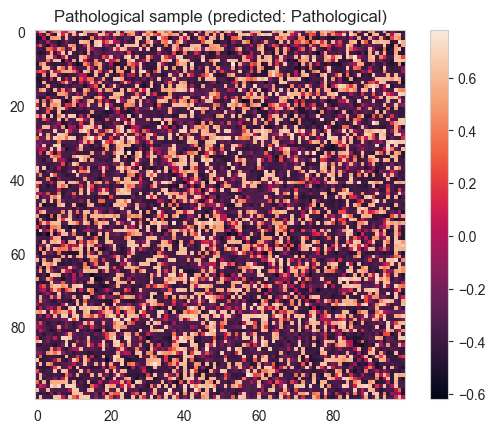

In [16]:
sample_idx = 1
sample = X_test_normalized[sample_idx]
label_gold = "Pathological" if y_gold_test[sample_idx] == 1 else "Control"
label_hat = "Pathological" if y_hat_test[sample_idx] == 1 else "Control"

plt.imshow(sample)
plt.colorbar()
plt.title(f"{label_gold} sample (predicted: {label_hat})")
plt.grid(False)
plt.show()

In [12]:
exp = explainer.explain_instance(
    X_test_normalized_flatten[sample_idx],
    partial(model.predict_proba, dataset_config=dataset_config),
    labels=(1,),
    num_features=10
)

In [13]:
# exp.show_in_notebook()
exp.save_to_file("lime-explanation.html")

In [14]:
test_explain_heatmap = np.zeros((100*100,))
for x in X_test_normalized_flatten[:1]:
    exp = explainer.explain_instance(
        x,
        partial(model.predict_proba, dataset_config=dataset_config),
        labels=(1,),
        num_features=100
    )
    lime_scores = exp.local_exp[1]
    for i, score in lime_scores:
        test_explain_heatmap[i] += score
test_explain_heatmap = test_explain_heatmap.reshape(100, 100)
np.save(os.path.join(RESULTS_PATH, "lime_heatmap.npy"), test_explain_heatmap)

<Axes: >

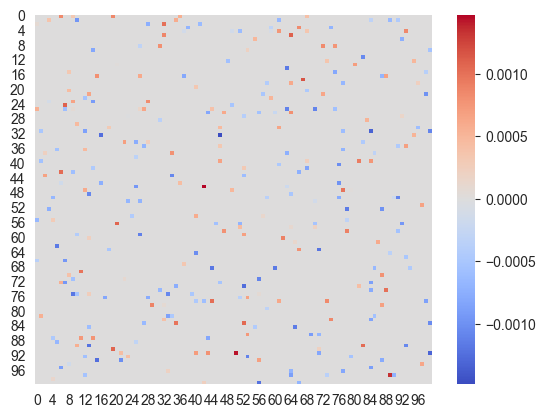

In [20]:
sns.heatmap(test_explain_heatmap, cmap="coolwarm", center=0)